In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import glob
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def img_undistort(img, mtx, dist):
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if orient == 'x':
        grad = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
        scaled_grad = np.uint8(255*grad/np.max(grad))
    if orient == 'y':
        grad = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
        scaled_grad = np.uint8(255*grad/np.max(grad))
    # Apply threshold
    grad_binary = np.zeros_like(img)
    grad_binary[(scaled_grad >= thresh[0]) & (scaled_grad <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gradx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    grady = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    magnitude = np.sqrt(gradx**2 + grady**2)
    # Apply threshold
    mag_binary = np.zeros_like(img)
    mag_binary[(magnitude >= mag_thresh[0]) & (magnitude <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gradx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    grady = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    direction = np.arctan2(grady, gradx)
    # Apply threshold
    dir_binary = np.zeros_like(img)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary

def color_select_S(img,thresh = (150,255)):
    select = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    binary_output = np.zeros_like(select)
    binary_output[(select >= thresh[0]) & (select <= thresh[1])] = 1
    return binary_output

def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, np.array([20,60,60]), np.array([38,174, 250]))
    return mask

def select_white(image):
    mask = cv2.inRange(image, np.array([202,202,202]), np.array([255,255,255]))
    return mask

def color_thresh(image):
    yellow = select_yellow(image)
    white = select_white(image)
    combined_binary = np.zeros_like(yellow)
    combined_binary[(yellow >= 1) | (white >= 1)] = 1
    return combined_binary

def combined_threshold(img, s_thresh_min=150, s_thresh_max=255):    
    ksize = 9 # Sobel kernel size
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 150))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 150))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_binary = color_select_S(img)  
    white_yellow = color_thresh(img)      
    combined = np.zeros_like(gray)
    combined[((gradx == 1) & (grady == 1))|((mag_binary == 1) & (dir_binary == 1))|(s_binary == 1)|(white_yellow == 1)] = 1    
    return combined

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def image_warp(img):     
    img_size = (img.shape[1], img.shape[0])    
    #print(imgsz)
    src = np.float32([
        [(img_size[0] / 2) - 55, img_size[1] / 2 + 90],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5.7 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 90]])

    dst = np.float32([
        [(img_size[0] / 4),0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)    
    return warped, M, Minv

def display_transformed_image(combined_binary, warped_img):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(combined_binary, cmap='gray')
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(warped_img,cmap='gray')
    ax2.set_title('Warped Image', fontsize=30)    
    plt.show()
    
def fit_2nd_order(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    #Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*(lefty**2) + left_fit[1]*lefty + left_fit[2]
    right_fitx = right_fit[0]*(righty**2) + right_fit[1]*righty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty
    
def find_lane_pixels(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        
        #Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_coeffs, right_coeffs,left_fitx, right_fitx, ploty = fit_2nd_order(binary_warped.shape, leftx, lefty, rightx, righty)

    return left_coeffs, right_coeffs, leftx, lefty, rightx, righty

def search_around_poly(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                    & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                    & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]    
    left_fit_new = []
    right_fit_new = []    
    if len(leftx) != 0:        
        left_fit_new = np.polyfit(lefty, leftx, 2)    
    if len(rightx) != 0:        
        right_fit_new = np.polyfit(righty, rightx, 2)     
    return left_fit_new, right_fit_new, leftx, lefty, rightx, righty

def draw_poly(img, poly_coeffs, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step
        start_point = (int(poly_coeffs[0]*start**2 + poly_coeffs[1]*start + poly_coeffs[2]), start)
        end_point = (int(poly_coeffs[0]*end**2 + poly_coeffs[1]*end + poly_coeffs[2]), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img

def trace_poly(color_canvas,image_both_drawn,left_coeffs, right_coeffs):
    trace = color_canvas
    trace[image_both_drawn > 1] = [0,0,255]

    area = image_both_drawn
    for y in range(0,image_both_drawn.shape[0]):
        left = left_coeffs[0]*y**2 + left_coeffs[1]*y + left_coeffs[2]
        right = right_coeffs[0]*y**2 + right_coeffs[1]*y + right_coeffs[2]
        area[y][int(left):int(right)] = 1

    trace[area == 1] = [0,255,0]
    return trace

def revert_back(trace, img, Minv):
    lane_lines = cv2.warpPerspective(trace, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    # Convert to colour
    combined_img = cv2.add(lane_lines, img)
    return combined_img
    

def curvature(left_coeffs, right_coeffs, leftx, lefty, rightx, righty):            
    y_eval = 719
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)


    left_curv = np.absolute(((1 + (2 * left_fit_cr[0] * y_eval*ym_per_pix + left_fit_cr[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
    right_curv = np.absolute(((1 + (2 * right_fit_cr[0] * y_eval*ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
    curvat = ((left_curv + right_curv) / 2)
    center = (1.5 * (left_coeffs[0]*719**2 + left_coeffs[1]*719 + left_coeffs[2]) - (right_coeffs[0]*719**2 + right_coeffs[1]*719 + right_coeffs[2])) / 2
    center = center * xm_per_pix
    min_curvature = min(left_curv, right_curv)
    return curvat, center, min_curvature

def find_lanes(img):
    global frame
    global left_fit
    global right_fit
    
    undist = img_undistort(img, mtx, dist)
    img_blur = cv2.GaussianBlur(img,(5,5),0)
    binary = combined_threshold(img_blur)
    imshape = img.shape
    vert = np.array([[(50, imshape[0]), (imshape[1], imshape[0]),(750, 420), (570, 420)]])
    masked_image = region_of_interest(binary,vert)
    warped, M, Minv = image_warp(masked_image)
    if frame == 0:
        left_fit, right_fit, leftx, lefty, rightx, righty = find_lane_pixels(warped)
        frame += 1
    else:
        left_fit, right_fit, leftx, lefty, rightx, righty = search_around_poly(left_fit, right_fit, warped)
        frame += 1
    
    blank_canvas = np.zeros((img.shape[0], img.shape[1]))
    color_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    
    left_fitted_image = draw_poly(blank_canvas, left_fit, 30)
    image_both_lines = draw_poly(left_fitted_image, right_fit, 30)
    
    canvas = trace_poly(color_canvas, image_both_lines, left_fit, right_fit)
    reverted_image = revert_back(canvas, img, Minv)
    curvat, center, min_curvature = curvature(left_fit, right_fit, leftx, lefty, rightx, righty)
    combined_img = reverted_image
    cv2.putText(combined_img, 'Radius of Curvature = %d(m)' % curvat, (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    left_or_right = "left" if center < 0 else "right"
    cv2.putText(combined_img, 'Vehicle is %.2fm %s of center' % (np.abs(center), left_or_right), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1,
                (255, 255, 255), 2)
    cv2.putText(combined_img, 'Min Radius of Curvature = %d(m)' % min_curvature, (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    return combined_img
    
    
    
    
    

## Image_pipeline

In [3]:
dist_pickle = pickle.load(open('camera_calibration.p','rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

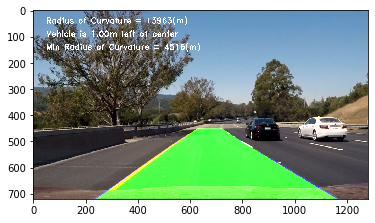

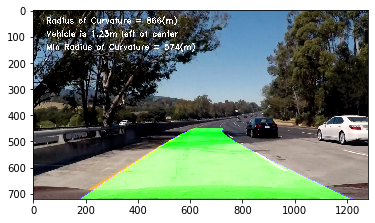

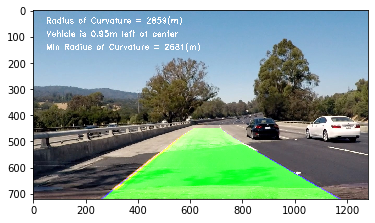

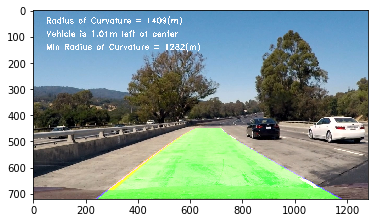

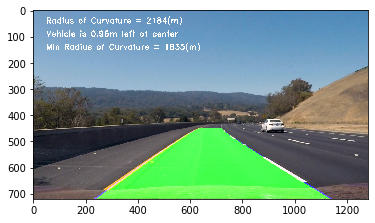

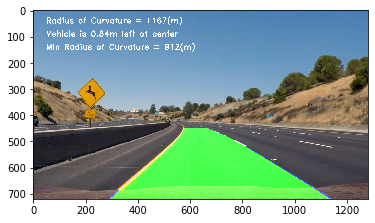

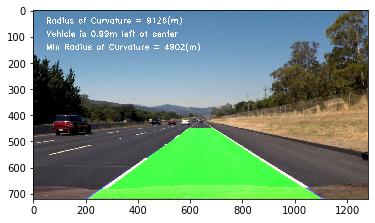

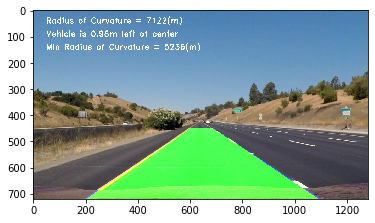

In [4]:
images = glob.glob('test_images/*.jpg')
for fname in images:
    image = mpimg.imread(fname)
    frame = 0
    left_fit = None
    right_fit = None
    final = find_lanes(image)
    plt.figure()
    plt.imshow(final)
    plt.imsave('test_images_output/'+fname.split('/')[1].split('.')[0]+'_output.jpg',final)

In [7]:
images

['test_images/test6.jpg',
 'test_images/test5.jpg',
 'test_images/test4.jpg',
 'test_images/test1.jpg',
 'test_images/test3.jpg',
 'test_images/test2.jpg',
 'test_images/straight_lines2.jpg',
 'test_images/straight_lines1.jpg']

## Video_pipeline

In [8]:
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
output = 'project_output_colour.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(find_lanes) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)


t:   0%|          | 2/1260 [00:00<01:51, 11.28it/s, now=None]

Moviepy - Building video project_output_colour.mp4.
Moviepy - Writing video project_output_colour.mp4



Moviepy - Done !
Moviepy - video ready project_output_colour.mp4
CPU times: user 15min 4s, sys: 1min 29s, total: 16min 33s
Wall time: 4min 13s


In [10]:
HTML("""<video width="900" height="400" controls><source src="{0}"></video>""".format(output))

In [11]:
output = 'challenge_output_colour.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
output_clip = clip1.fl_image(find_lanes) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)


t:   0%|          | 2/485 [00:00<00:43, 11.16it/s, now=None]

Moviepy - Building video challenge_output_colour.mp4.
Moviepy - Writing video challenge_output_colour.mp4



Moviepy - Done !
Moviepy - video ready challenge_output_colour.mp4
CPU times: user 4min 38s, sys: 26.7 s, total: 5min 4s
Wall time: 1min 14s


In [12]:
HTML("""<video width="900" height="400" controls><source src="{0}"></video>""".format(output))